## Introduction



This is a tutorial of generation of simulations and projection. We first specify two templates, one
in equatorial coordinates with `CAR` pixellisation and one in equatorial coordinates with `HEALPIX`
pixellisation. We generate alms from a `CAMB` lensed power spectrum file and use them to generate a
random CMB realisation in both templates. We then project the `HEALPIX` simulation into the CAR template and plot both the
native `CAR` simulation and the projected `HEALPIX` simulation. We chose a low resolution `nside` to
emphasize the effect of resolution



## Preamble



`matplotlib` magic



In [1]:
%matplotlib inline

Print versions used



In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pspy, pixell
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    pixell :", pixell.__version__)
print("      pspy :", pspy.__version__)

     Numpy : 1.18.0
Matplotlib : 3.1.2
    pixell : 0.6.0+34.g23be32d
      pspy : 0+untagged.118.gbf1f0bc.dirty


Get default data dir from `pspy` and set Planck colormap as default



In [3]:
from pspy.so_config import DEFAULT_DATA_DIR
pixell.colorize.mpl_setdefault("planck")

## Generation of the templates



The `CAR` template will go from right ascension `ra0` to `ra1` and from declination `dec0` to `dec1` (all in
degrees). It will have a resolution of 1 arcminute and it allows 3 components (stokes parameter in
the case of CMB anisotropies).



In [4]:
ra0, ra1 = -5, 5
dec0, dec1 = -5, 5
res = 1
ncomp = 3
from pspy import so_map
template_car = so_map.car_template(ncomp, ra0, ra1, dec0, dec1, res)

We also generate an `HEALPIX` template for which we choose `nside=256` so that the resolution of `HEALPIX`
is much smaller



In [5]:
template_healpix = so_map.healpix_template(ncomp, nside=256, coordinate="equ")

## Read power spectrum and alm generation



We first have to compute the power spectra $C_\ell$s  using a Boltzmann solver such as [CAMB](https://camb.readthedocs.io/en/latest/) and we need to install it
since this is a prerequisite of `pspy`. We can do it within this notebook by executing the following
command



In [6]:
%pip install camb

Note: you may need to restart the kernel to use updated packages.


To make sure everything goes well, we can import `CAMB` and check its version



In [7]:
import camb
print("CAMB version:", camb.__version__)

CAMB version: 1.1.0


Now that `CAMB` is properly installed, we will produce $C_\ell$ data from $\ell$<sub>min</sub>=2 to
$\ell$<sub>max</sub>=10<sup>4</sup> for the following set of $\Lambda$CDM parameters



In [8]:
lmin, lmax = 2, 10**4
l = np.arange(lmin, lmax)
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

We finally have to write $C_\ell$ into a file to read back using the `pixell.powspec` function



In [9]:
import os
output_dir = "/tmp/tutorial_projection"
os.makedirs(output_dir, exist_ok=True)
cl_file = output_dir + "/cl_camb.dat"
np.savetxt(cl_file,
           np.hstack([l[:, np.newaxis], powers["total"][lmin:lmax]]))

from pixell import powspec
ps = powspec.read_spectrum(cl_file)[:ncomp,:ncomp]

and generate alms from the power spectrum up to `lmax = 5000`



In [10]:
from pixell import curvedsky
lmax = 5000
alms = curvedsky.rand_alm(ps, lmax=lmax)

## Computation of stokes parameters



We compute the stokes parameters from the alms in both templates



In [11]:
from pspy import sph_tools
map_healpix = sph_tools.alm2map(alms, template_healpix)
map_car = sph_tools.alm2map(alms, template_car)

and we project the `HEALPIX` map into the `CAR` template



In [12]:
map_healpix_proj = so_map.healpix2car(map_healpix, map_car, lmax=lmax)

Preparing SHT
T -> alm
float64 complex128
P -> alm
Projecting


## Showing maps



We plot both the native `CAR` map and the `HEALPIX` projected to `CAR` map. They contain the same CMB but
have different resolutions.



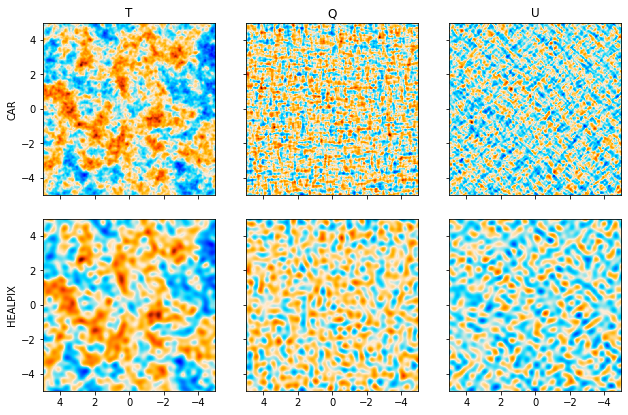

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
fields = ["T", "Q", "U"]
kwargs = dict(extent=[ra1, ra0, dec0, dec1], origin="lower")
for i, field in enumerate(fields):
    kwargs["vmin"] = np.min([map_car.data[i], map_healpix_proj.data[i]])
    kwargs["vmax"] = np.max([map_car.data[i], map_healpix_proj.data[i]])
    axes[0, i].imshow(map_car.data[i], **kwargs)
    axes[1, i].imshow(map_healpix_proj.data[i], **kwargs)
    axes[0, i].set_title(fields[i])

axes[0, 0].set_ylabel("CAR")
axes[1, 0].set_ylabel("HEALPIX")
plt.tight_layout()

We can also use the `plot` function from `pspy.so_map` and set the output path to get individual images
for each component T, Q, U.



In [14]:
map_car.plot(file_name=output_dir + "/map_car")
map_healpix_proj.plot(file_name=output_dir + "/map_healpix")